In [1]:
import numpy as np
import pandas as pd
import os
import sys
import gc
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

在这一部分中，将进行以下三个部分的工作：
* 特征选择
* 模型选择
* 模型超参数优化

## 1 特征选择
导入在上一节中已经提取到的特征数据集

In [2]:
all_data = pd.read_csv("../data/all_engineered.csv")

查看数据类型

In [3]:
Id = all_data['SK_ID_CURR']
Target = all_data['TARGET']
all_data = all_data.drop(columns=['SK_ID_CURR','TARGET'])

In [4]:
print(all_data.shape)

(356255, 880)


经过我们上一步的数据提取，已经得到一个包含880维特征的预测特征数据集，这些特征之间可能存在高度共线性，也可能存在缺失比例过高等情况，在后续的特征选择的过程中，我们都需要注重关注这些情况。

In [5]:
display(all_data.dtypes.value_counts())

float64    704
int64      176
dtype: int64

检查一下，是否有ID类的组合特征

In [6]:
cols_with_id = [x for x in all_data.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in all_data.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in all_data.columns if 'SK_ID_PREV' in x]
print('There are {} columns that contain SK_ID_CURR'.format(len(cols_with_id)))
print('There are {} columns that contain SK_ID_BUREAU'.format(len(cols_with_bureau_id)))
print('There are {} columns that contain SK_ID_PREV'.format(len(cols_with_previous_id)))

There are 0 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV


计算特征之间的共线性，如果以完整数据集计算的话，会非常的耗时，因此，这里仅抽样了10000条数据，大致估计特征之间的线性相关性系数。

In [7]:
threshold = 0.9
corr_matrix = all_data.sample(10000).corr().abs()
corr_matrix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,PREVIOUS_AMT_APPLICATION_sum,PREVIOUS_DAYS_FIRST_DRAWING_min,PREVIOUS_DAYS_FIRST_DRAWING_mean,PREVIOUS_DAYS_FIRST_DRAWING_max,PREVIOUS_RATE_INTEREST_PRIMARY_min,PREVIOUS_RATE_INTEREST_PRIMARY_mean,PREVIOUS_RATE_INTEREST_PRIMARY_max,PREVIOUS_RATE_INTEREST_PRIVILEGED_min,PREVIOUS_RATE_INTEREST_PRIVILEGED_mean,PREVIOUS_RATE_INTEREST_PRIVILEGED_max
AMT_ANNUITY,1.000000,0.765286,0.770453,0.384267,0.005612,0.012980,0.037003,0.007532,0.015152,0.021565,...,0.119912,0.066410,0.066530,0.066558,0.044485,0.044649,0.044779,0.009809,0.010273,0.010651
AMT_CREDIT,0.765286,1.000000,0.986994,0.283972,0.011921,0.021443,0.067712,0.001698,0.010330,0.050130,...,0.121805,0.138699,0.139318,0.139743,0.020047,0.019950,0.019837,0.019384,0.019910,0.020267
AMT_GOODS_PRICE,0.770453,0.986994,1.000000,0.290709,0.012141,0.019394,0.068698,0.004297,0.009436,0.050537,...,0.124806,0.142620,0.143291,0.143764,0.026279,0.026026,0.025752,0.020505,0.021584,0.022482
AMT_INCOME_TOTAL,0.384267,0.283972,0.290709,1.000000,0.008817,0.005623,0.044932,0.003490,0.009971,0.007352,...,0.190404,0.017341,0.017038,0.016710,0.038100,0.036706,0.035283,0.094761,0.090525,0.085494
AMT_REQ_CREDIT_BUREAU_DAY,0.005612,0.011921,0.012141,0.008817,1.000000,0.367286,0.002859,0.002388,0.214875,0.024567,...,0.010056,0.005599,0.005516,0.005425,0.014044,0.013868,0.013683,0.079461,0.079305,0.078638


In [8]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
upper.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,PREVIOUS_AMT_APPLICATION_sum,PREVIOUS_DAYS_FIRST_DRAWING_min,PREVIOUS_DAYS_FIRST_DRAWING_mean,PREVIOUS_DAYS_FIRST_DRAWING_max,PREVIOUS_RATE_INTEREST_PRIMARY_min,PREVIOUS_RATE_INTEREST_PRIMARY_mean,PREVIOUS_RATE_INTEREST_PRIMARY_max,PREVIOUS_RATE_INTEREST_PRIVILEGED_min,PREVIOUS_RATE_INTEREST_PRIVILEGED_mean,PREVIOUS_RATE_INTEREST_PRIVILEGED_max
AMT_ANNUITY,NaN,0.765286,0.770453,0.384267,0.005612,0.012980,0.037003,0.007532,0.015152,0.021565,...,0.119912,0.066410,0.066530,0.066558,0.044485,0.044649,0.044779,0.009809,0.010273,0.010651
AMT_CREDIT,NaN,NaN,0.986994,0.283972,0.011921,0.021443,0.067712,0.001698,0.010330,0.050130,...,0.121805,0.138699,0.139318,0.139743,0.020047,0.019950,0.019837,0.019384,0.019910,0.020267
AMT_GOODS_PRICE,NaN,NaN,NaN,0.290709,0.012141,0.019394,0.068698,0.004297,0.009436,0.050537,...,0.124806,0.142620,0.143291,0.143764,0.026279,0.026026,0.025752,0.020505,0.021584,0.022482
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.008817,0.005623,0.044932,0.003490,0.009971,0.007352,...,0.190404,0.017341,0.017038,0.016710,0.038100,0.036706,0.035283,0.094761,0.090525,0.085494
AMT_REQ_CREDIT_BUREAU_DAY,NaN,NaN,NaN,NaN,NaN,0.367286,0.002859,0.002388,0.214875,0.024567,...,0.010056,0.005599,0.005516,0.005425,0.014044,0.013868,0.013683,0.079461,0.079305,0.078638


In [9]:
to_drop = [column for column in upper.columns if any(upper[column]>threshold)]
print('There are {} columns to remove.'.format(len(to_drop)))

There are 201 columns to remove.


从1000条样本的估计结果来看，有186组特征之间存在着高于90%的线性相关性。这些两两的特征组合中，需求删除其中一个，仅留下其中一个。

In [10]:
all_data = all_data.drop(columns=to_drop)
print('all_data shape: {}'.format(all_data.shape))

all_data shape: (356255, 679)


删除缺失率高于60%的特征

In [11]:
data_missing = (all_data.isnull().sum() / len(all_data)).sort_values(ascending = False)
data_missing.head()

PREVIOUS_RATE_INTEREST_PRIVILEGED_min    0.983941
COMMONAREA_AVG                           0.697141
NONLIVINGAPARTMENTS_AVG                  0.692933
FLOORSMIN_AVG                            0.676785
BUREAU_LOAN_RATE_mean                    0.669316
dtype: float64

In [12]:
data_missing = data_missing.index[data_missing > 0.60]

In [13]:
data_missing = list(data_missing)
print('There are {} columns with more than 60% missing values'.format(len(data_missing)))

There are 92 columns with more than 60% missing values


In [14]:
all_data = all_data.drop(columns=data_missing)
print('Data set full shape: {}'.format(all_data.shape))

Data set full shape: (356255, 587)


经过这样简单的特征选择之后，最终的预测特征还有587维。

In [15]:
miss_ratios = all_data.isnull().mean()

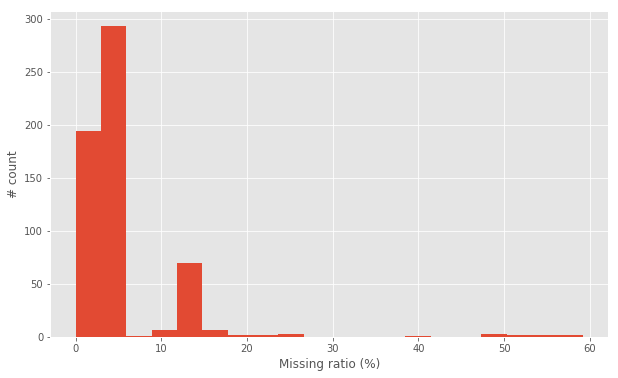

In [16]:
plt.figure(figsize=(10,6))
plt.hist(miss_ratios.values*100,bins=20)
plt.xlabel('Missing ratio (%)')
plt.ylabel('# count')
plt.show()

In [17]:
all_data.dtypes[miss_ratios>0].value_counts()

float64    402
dtype: int64

仍然存在缺失情况的特征有406维，不过从上图中也看到，大部分的数据缺失比例已经不高了，控制在了15%以内。现阶段，我们采取以0填补缺失值的方式，有时间的话可以做更加细致的分析。

In [18]:
all_data = all_data.fillna(0)

In [19]:
all_data.isnull().sum().sum()

0

In [20]:
feature_names = all_data.columns.tolist()

In [21]:
gc.collect()

3318

#### 特征归一化
将预测变量的范围都归一化到[0,1]之间，对于一些对特征大小敏感的算法，这样可以使得各个特征权重在同一个水平，更容易找到好的模型解。

受限于电脑内存，不能调用sklearn的MinMaxScaler的函数，自己编写了一个循环体也能执行同样的操作

In [22]:
for col in tqdm(feature_names):
    all_data[col] = (all_data[col]-all_data[col].min())/(all_data[col].max()-all_data[col].min())

100%|██████████| 587/587 [00:30<00:00, 19.06it/s]


将预测变量重新分割为训练集和测试集

In [23]:
x_train = all_data[Target.notnull()]
x_test = all_data[Target.isnull()]
y_train = Target[Target.notnull()]
y_test = Target[Target.isna()]

In [24]:
print(x_train.shape)
print(x_test.shape)

(307511, 587)
(48744, 587)


In [25]:
del all_data, Target

## 2模型选择

#### 简单模型 1: Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve

5-fold交叉验证法

In [27]:
lr_fit = LogisticRegression(C=1e-3,class_weight='balanced',penalty='l2',random_state=1,max_iter=1000,n_jobs=1)
lr_cv = cross_val_score(estimator=lr_fit,X=x_train,y=y_train,cv=5,scoring='roc_auc',n_jobs=2,verbose=True)

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


In [28]:
lr_cv.mean()

0.7573542603370559

In [29]:
lr_fit.fit(x_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

5-fold交叉验证的结果，逻辑回归的验证集AUC均值为0.757。

In [30]:
lr_pred_train = lr_fit.predict_proba(x_train)[:,1]

In [31]:
fpr,tpr,_ = roc_curve(y_true=y_train,y_score=lr_pred_train)
auc_score = roc_auc_score(y_true=y_train,y_score=lr_pred_train)

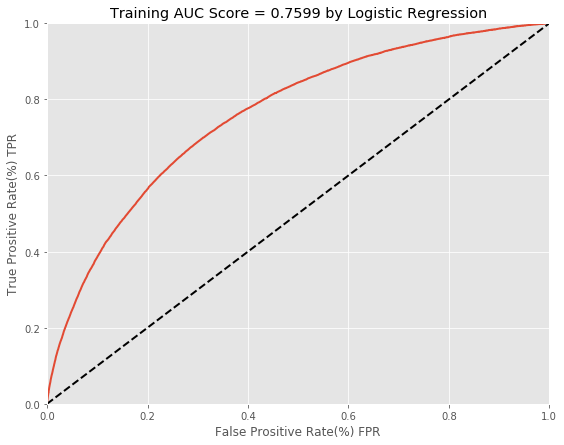

In [32]:
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,linewidth=2,label='lr_roc_curve')
plt.plot([0,1],[0,1],'k--',linewidth=2)
plt.xlim([0,1])
plt.xlabel('False Prositive Rate(%) FPR')
plt.ylim([0,1])
plt.ylabel('True Prositive Rate(%) TPR')
plt.title("Training AUC Score = {:.4f} by Logistic Regression".format(auc_score))
plt.show()

In [33]:
lr_pred = lr_fit.predict_proba(x_test)[:,1]

In [34]:
submit = pd.read_csv("../data/sample_submission.csv")
display(submit.head())

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [35]:
lr_submit = submit.copy()
lr_submit['TARGET'] = lr_pred

In [36]:
lr_submit.to_csv("../data/lr_submit.csv",index=False)

public score: 0.758

#### LightGBM

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [39]:
predictor_names = x_train.columns.tolist()
categorical_features = None

In [53]:
Dtrain = lgb.Dataset(data=x_train.values,label=y_train.values,free_raw_data=False)
train_X,valid_X,train_y,valid_y = train_test_split(x_train,y_train,stratify=y_train,random_state=2018)
dtrain = lgb.Dataset(data=train_X.values,label=train_y.values,feature_name=predictor_names,categorical_feature=None,free_raw_data=False)
dvalid = lgb.Dataset(data=valid_X.values,label=valid_y.values,feature_name=predictor_names,categorical_feature=None,free_raw_data=False)

In [60]:
def lgb_evaluate_cv(colsample_bytree=0.5,
                    learning_rate=0.1,num_leaves=7,
                    subsample=0.8,reg_alpha=0.0,
                    reg_lambda=0.0,min_child_weight=0.0):
    params = dict()
    params['colsample_bytree'] = max(min(colsample_bytree,1),0)
    params['learning_rate'] = max(min(learning_rate,1),0)
    params['num_leaves'] = int(num_leaves)
    params['subsample'] = max(min(subsample,1),0)
    params['reg_alpha'] = max(0,reg_alpha)
    params['reg_lambda'] = max(0,reg_lambda)
    params['min_child_weight'] = int(min_child_weight)
    params['is_unbalance'] = True
    params['categorical_features'] = categorical_features
    params['predictor'] = predictor_names
    params['objective'] = 'binary'
    cv_result =  lgb.cv(params=params,train_set=Dtrain,
                        early_stopping_rounds=50,
                        metrics='auc',nfold=5,
                        num_boost_round=1000,
                        verbose_eval=False,seed=1,show_stdv=True)                       
    return cv_result['auc-mean'][-1]

In [61]:
lgb_evaluate_cv()

0.7803322770177153

In [62]:
params = dict()
params['colsample_bytree'] = 0.7
params['learning_rate'] = 0.1
params['num_leaves'] = 15
params['subsample'] = 0.9
params['reg_alpha'] = 0.0
params['reg_lambda'] = 0.0
params['min_child_weight'] = 0.0
params['is_unbalance'] = True
params['categorical_features'] = categorical_features
params['predictor'] = predictor_names
params['objective'] = 'binary'
params['metrics'] = 'auc'

In [63]:
lgb_opt = lgb.train(params=params,train_set=dtrain,valid_sets=[dtrain,dvalid],valid_names=['train','valid'],verbose_eval=50,early_stopping_rounds=30,num_boost_round=1000)

Training until validation scores don't improve for 30 rounds.
[50]	train's auc: 0.780999	valid's auc: 0.767247
[100]	train's auc: 0.79814	valid's auc: 0.775243
[150]	train's auc: 0.80996	valid's auc: 0.777484
[200]	train's auc: 0.819385	valid's auc: 0.77818
Early stopping, best iteration is:
[207]	train's auc: 0.82067	valid's auc: 0.778338


In [67]:
lgb_opt = lgb.train(params=params,train_set=Dtrain,valid_sets=[Dtrain],valid_names=['train'],verbose_eval=20,num_boost_round=207)

[20]	train's auc: 0.758506
[40]	train's auc: 0.773255
[60]	train's auc: 0.782194
[80]	train's auc: 0.788697
[100]	train's auc: 0.793708
[120]	train's auc: 0.798043
[140]	train's auc: 0.801782
[160]	train's auc: 0.805183
[180]	train's auc: 0.808531
[200]	train's auc: 0.811659


In [75]:
feature_importance = pd.DataFrame(data=lgb_opt.feature_importance(),columns=['value'],index=predictor_names)

In [78]:
feature_importance = feature_importance.sort_values('value',ascending=False)
feature_importance.head()

,value
CREDIT_TERM,151
DAYS_BIRTH,71
PREVIOUS_DAYS_LAST_DUE_1ST_VERSION_max,71
AMT_ANNUITY,60
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,46


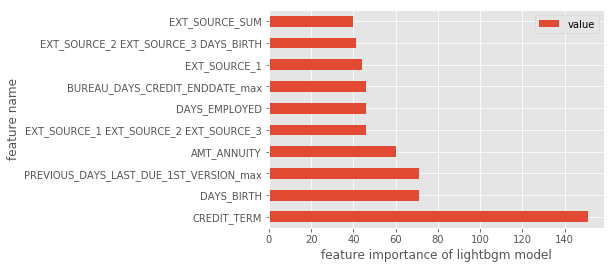

In [88]:
feature_importance.head(10).plot(kind='barh')
plt.xlabel('feature importance of lightbgm model')
plt.ylabel('feature name')
plt.show()

In [90]:
display(feature_importance.head(10))

,value
CREDIT_TERM,151
DAYS_BIRTH,71
PREVIOUS_DAYS_LAST_DUE_1ST_VERSION_max,71
AMT_ANNUITY,60
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,46
DAYS_EMPLOYED,46
BUREAU_DAYS_CREDIT_ENDDATE_max,46
EXT_SOURCE_1,44
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,41
EXT_SOURCE_SUM,40


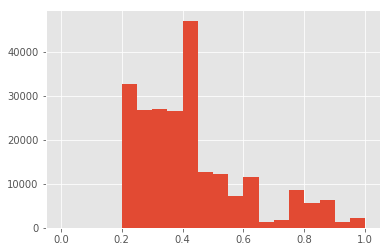

In [133]:
plt.hist(train_X['CREDIT_TERM'],bins=20)
plt.show()

In [128]:
CREDIT_TERM = pd.cut(train_X['CREDIT_TERM'],20).to_frame()
CREDIT_TERM['TARGET'] = train_y

In [129]:
s = CREDIT_TERM.groupby('CREDIT_TERM')['TARGET'].mean()

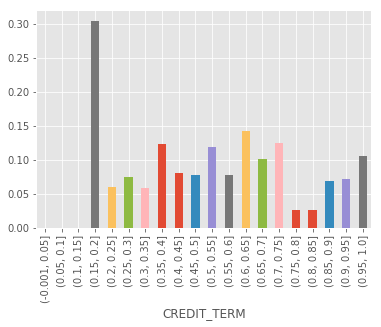

In [130]:
s.plot(kind='bar')